<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/TFAgents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-Agents para jugar Breakout

-- La librería de aprendizaje por refuerzo de tensorflow
[tfagents](https://www.tensorflow.org/agents?hl=es-419)

-- Se utilizará TF-Agents para crear una agente que aprenderá a jugar [Breakout](https://elgoog.im/breakout/). 


-- Se utilizará el algoritmo Deep Q-Learning.

-- TF-Agents permite utilizar wrappers y redes DQN convencionales, como las utilizadas en el cartpole, y otras más sofisticadas!


## Instalación y configuracíon requerida

In [81]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

## Ambientes TF-Agents

-- El ambiente de TF agents, entre muchas de sus funcionalidades, actua como wrapper del OpenAI gym.

-- Se creará un escenario del juego Breakout

In [82]:
tf.random.set_seed(42)
np.random.seed(42)

In [83]:
#cargar datos desde drive acceso libre
FILEID = "170ydHobjaRdeZjryXbAYYAEfc1TMZPmd"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ROMS.zip && rm -rf /tmp/cookies.txt
#!unzip codigos.zip
#!dir

--2021-06-10 20:21:04--  https://docs.google.com/uc?export=download&confirm=&id=170ydHobjaRdeZjryXbAYYAEfc1TMZPmd
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-14-docs.googleusercontent.com/docs/securesc/lhbmentvhg5lk9qv1895ko49ld5sfvmk/g2um6he91u0c6fg4pddak7v0m99nnjkf/1623356400000/09173029842254050324/02245014981830098616Z/170ydHobjaRdeZjryXbAYYAEfc1TMZPmd?e=download [following]
--2021-06-10 20:21:07--  https://doc-0k-14-docs.googleusercontent.com/docs/securesc/lhbmentvhg5lk9qv1895ko49ld5sfvmk/g2um6he91u0c6fg4pddak7v0m99nnjkf/1623356400000/09173029842254050324/02245014981830098616Z/170ydHobjaRdeZjryXbAYYAEfc1TMZPmd?e=download
Resolving doc-0k-14-docs.googleusercontent.com (doc-0k-14-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-0k-14

In [84]:
!python -m atari_py.import_roms ./

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [85]:
import atari_py
print(atari_py.list_games())

['tetris', 'star_gunner', 'asteroids', 'asterix', 'berzerk', 'breakout', 'pacman', 'jamesbond', 'frogger', 'journey_escape', 'kung_fu_master', 'phoenix', 'robotank', 'kaboom', 'road_runner', 'kangaroo', 'amidar', 'freeway', 'galaxian', 'defender', 'gopher', 'skiing', 'mr_do', 'double_dunk', 'name_this_game', 'riverraid', 'pong', 'gravitar', 'solaris', 'carnival', 'seaquest', 'hero', 'krull', 'yars_revenge', 'video_pinball', 'qbert', 'chopper_command', 'battle_zone', 'demon_attack', 'bowling', 'wizard_of_wor', 'alien', 'beam_rider', 'zaxxon', 'laser_gates', 'time_pilot', 'fishing_derby', 'enduro', 'koolaid', 'lost_luggage', 'donkey_kong', 'ice_hockey', 'king_kong', 'atlantis', 'keystone_kapers', 'sir_lancelot', 'tutankham', 'up_n_down', 'pitfall', 'boxing', 'surround', 'ms_pacman', 'assault', 'trondead', 'space_invaders', 'bank_heist', 'venture', 'adventure', 'tennis', 'pooyan', 'crazy_climber', 'private_eye', 'montezuma_revenge', 'air_raid', 'centipede', 'elevator_action', 'frostbite']

# Para la lista de escenarios de atari aceptados ver [https://gym.openai.com/envs/#atari](https://gym.openai.com/envs/#atari)

In [86]:
from tf_agents.environments import suite_gym

env_name = "Breakout-v4"#"Assault-v0" #"Pong-v0"
env = suite_gym.load(env_name) # se puede fijar el discount= xxx (discount factor)
env

In [87]:
env.gym

-- A diferencia del OpenAI, tf agents tiene un método `reset()` que no devuelve una observación, devuelve un `TimeStep` que actúa como wrapper de la observación.


In [88]:
env.seed(42)
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

-- El método `step()` también devuelve un objeto `TimeStep`

In [89]:
env.step(1) # Fire

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})

-- El atributo `step_type` es 0 para el primer time step del episodio, 1 para time steps intermedios y 2 para el step final.

-- Se puede llamar al método `is_last()` del `TimeStep` para saber si es el paso final.

-- `discount` indica el discount factor que se usa en cada paso (se puede fijar cuando se carga el ambiente).

Saving figure breakout_plot


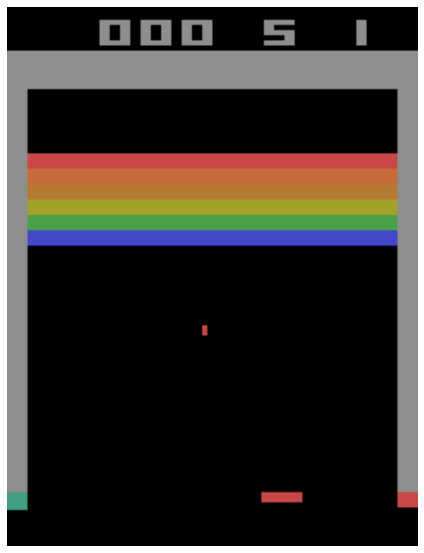

In [90]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [91]:
env.current_time_step()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})

## Especificaciones del ambiente (escenario)

-- TF agents provee especificaciones de las observaciones, acciones, y time steps.

In [92]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [93]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [94]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

-- En este caso las observaciones son frames (imágenes) de la pantalla del Atari, en numpy arrays de [210,160,3].



In [95]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

-- En este caso tenemos cuatro acciones disponibles.

-- La representación de las observaciones (imagenes), deben ser submuestreadas y convertidas a escala de grises para preservar memoría RAM.

-- Para ello se puede utilizar un *environment wrapper*.

## Environment Wrappers y preprocesamiento en Atari



In [96]:
import tf_agents.environments.wrappers # lista de wrappers disponibles

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
ExtraDisabledActionsWrapper Adds extra unavailable actions.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls

In [97]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4) # se repite la accion 4 veces
repeating_env

In [98]:
repeating_env.unwrapped # el tf agent contiene el escenario de Atari

-- El método `suite_gym.load()` crea un escenario y codifica (wrap) para TF-Agents environment wrappers y Gym environment wrappers.

-- Se creará un código que construye un ambiente BreakOut y correrá por un máximo de 10.000 pasos durante cada episodio, y cada acción se repite 4 veces:

In [99]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [100]:
limited_repeating_env

In [101]:
limited_repeating_env.unwrapped

-- En la mayoría de ocasiones se requiere aplicar algunas etapas de preprocesamiento.

-- Tf agents proporciona una serie de wrappers desde el  `AtariPreprocessing`, que incluye:
  -`Grayscale and downsampling`: se muestrea a 84 x 84 pixeles por defecto.
  - `Max pooling`: los últimos dos frames se filtran con max pooling de 1 x 1.
  - `Frame skipping`: el agente solo ve cada $n$ frames (por defecto 4).
  - `End of life lost`: el episodio termina justo cuando se pierde una vida.

-- Se creará un escenario Atari Breakout y se le aplicarán algunas etapas de preproceso.

-- Por defecto Atari aplica frame skipping y max pooling, por ende se llamará la variante `BreakoutNoFrameskip-v4`.

-- Para codificar la velocidad, utilizaremos el `FrameStack4`, el cual retorna una serie de cuatro frames sobre la dimensión de canales de la imagen.

**Nota:** Breakout requiere que el usuario presione el botón FIRE para iniciar o al perder una vida. El agente puede tardar mucho en aprender esto, dado que puede entender que es una forma de perder rápido. Para acelerar el entrenamiento se creará la subclase del `AtariPreprocessing` wrapper, llamada `AtariPreprocessingWithAutoFire`, que presiona FIRE (i.e., plays action 1) automáticamente al empezar el juego o perder una vida.

In [102]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # 
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [103]:
env

-- Juguemos unos cuantos pasos:

In [104]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [105]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


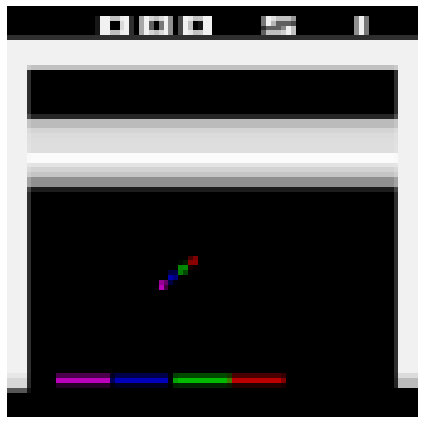

In [106]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

-- Ahora construiremos el Python environment a TF environment:

In [107]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

-- Lo anterior permitirá que el escenario sea compatible con un grafo computacional de TensorFlow.

-- Ya se tiene un escenario de Breakout, con el preprocesamiento requerido y que sea compatible con TensorFlow.

-- Podemos entrenar una DQN y otros componentes.



# Arquitectura de entrenamiento

-- En tf-Agents, el proceso de entrenamiento se divide generalmente en dos partes que se ejecutan en paralelo: *Collection* y *Training*.

- **Driver**: explora el escenario con una policy que determina las acciones, y además recoge trayectorias (experiencias) que son enviadas al observer.

- **Observer**: el observador las guarda y envia al replay buffer. Pretende hacer la arquitectura más flexible, ej., no utilizar un replay buffer.

- **Agent**: el agente toma lotes (batches) de trayectorias del replay buffer y entrena algunas redes neuronales que son usadas por el collect policy.

- **Trajectory**: es una representación de una transición de un paso al siguiente, o una secuencias de transiciones consecutivas de un paso $n$ a un paso $n+t$.

-- En resumen los elementos del lado izquierdo de la figura exploran el escenario y recogen experiencias, mientras que el lado derecho aprende y actualiza las policy.

-- Se construyen múltiples escenarios para explorar múltiples copias del escenario en paralelo (aprovechar CPU workers).

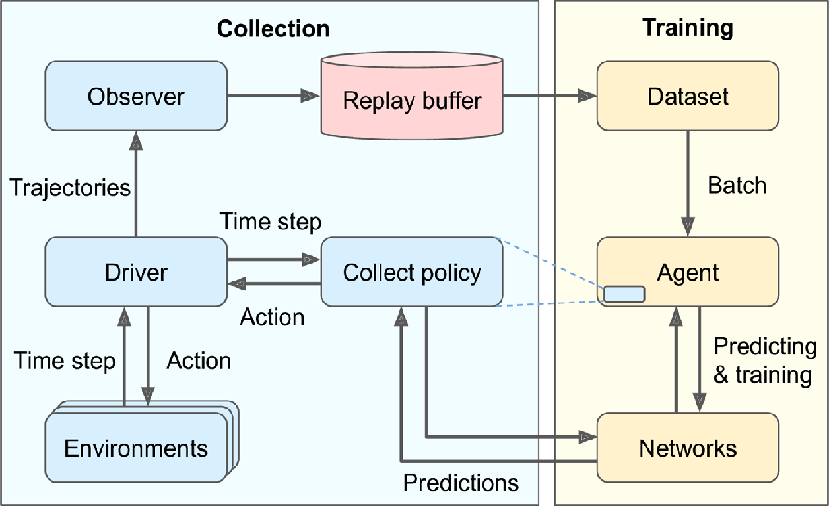

## Crear una DQN

-- La DQN tomará una observación como entrada y estimará el Q-Value por acción.

-- Se crea una clase que normaliza las observacioens. 

-- **Nota**: algunos modelos pueden incluir más de una entrada, ej.: algún sensor más imágenes.

-- [Documentación QNetwork](https://www.tensorflow.org/agents/api_docs/python/tf_agents/networks/q_network/QNetwork)

In [108]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.) #se normalizan imágenes de 0 a 1 en flotante
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)] #ej: 32 filtros, de 8 x 8  con stride 4
fc_layer_params=[512] # capa densa con 512 units seguida de otra densa con 4 unidades: una por cada Q-value (por acción)
# Por defecto se usan activaciones ReLU (ver argumento activation_fn), exceptuando la última capa

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params) #

## Crear el agente DQN:

-- Se crea una variable que cuenta el número de pasos de entrenamiento

-- Se inlcuye un optimizador.

-- Se plantea un `PolynomialDecay` para calcular el valor de $\epsilon$ ($\epsilon$ greedy collect policy) con base en el paso actual de entrenamiento. Se fija el rango de variacíon en [1.0, 0.01] para 250.000 pasos.

-- Luego se crea el `DQNAgent` que recibe el TimeStep y action specs, la red QNetwork a entrenar, el optimizador, el número de pasos de entrenamiento, la función de costo, el factor de descuento, la variable `train_step` y la función que retorna el $\epsilon$.

In [109]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # se entrena el agente cada 4 pasos
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True) #hyperparámetros segun paper DeepMind DQN 2015
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net, #Qnet definada en celdas anteriores
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"), #error calculado por instancia, no el promedio
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Construyendo el replay buffer y el observador

-- `tf_agents.replay_buffers` provee varias implementaciones de replay buffer.

-- `TFUniformReplayBuffer` provee un muestreo uniforme del replay buffer.

-- Se creará un replay buffer (tener cuidado con la RAM disponible)



In [110]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, #formato de los datos desde el agente DQN 
    batch_size=tf_env.batch_size, #experiencias para cada paso, en este caso el driver ejecutara una acción por paso
    max_length=50000) # reducir si genera error de memoría - valor originial 100.000

replay_buffer_observer = replay_buffer.add_batch

-- Se creará un observador que enviará las trayectorias (experiencias) al replay buffer.

-- El observador también contará y mostrará el número de veces que es ejecutado (excepto cuando pasa la trayectoria que representa el salto entre dos episodios)

In [111]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0 #inicializar contador
        self.total = total 
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1 #incrementar contador
        if self.counter % 100 == 0: #mostrar en pantalla
            print("\r{}/{}".format(self.counter, self.total), end="")

## Métricas para el entrenamiento

En este caso se consideran:

-- El conteo de episodios
-- El número de pasos
-- **El retorno promedio por episodio**
-- **La longitud promedio por episodio**

In [112]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(), #promedio de rewards no descontados por episodio
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [113]:
train_metrics[0].result() #obtener el valor de la métrica respectiva

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [114]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics) #log todas las métricas

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


## Collect driver

-- El driver explorar el escenario desde una policy dada.

-- Además, guarda las experiencias y las envia a los observadores (recuerde que el observador facilita el trabajo del driver, en cuanto al guardado de trayectorias, la medición de métricas, etc.).

-- El driver pasa el time step actual al collect policy, el cual escoge una acción y retorna un action step.


-- El driver pasa la acción al escenario, el cual retorna el siguiente time step.

-- Por último el driver crea un objeto trayectoria (experiencia) y lo pasa a los observadores.

-- **Tipos de driver**: `DynamicStepDriver` (por pasos) vs `DynamicEpisodeDriver` (por episodios).

-- En este caso se coleccionan experiencias por cuatro pasos en cada iteración de entrenamiento.

In [115]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # 4 pasos por cada iteración de entrenamiento

-- Antes de ejecutar el driver, se sugiere inicializar el replay buffer con experiencias aleatorias (`RandomTFPolicy`).

In [116]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver( #driver para ejecutar las policy aleatorias
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

-- Se muestrean dos episodios, con tres time steps:

**Nota**: `replay_buffer.get_next()` se desprecia. Se debe usar `replay_buffer.as_dataset(..., single_deterministic_pass=False)`.

In [117]:
tf.random.set_seed(9) # chosen to show an example of trajectory at the end of an episode

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Crear el dataset

-- Para muestrear un batch de trayectorias del replay buffer, se utiliza el método `get_next()`.

In [118]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [119]:
trajectories.observation.shape # dos trayectorias, tres pasos, cada observación en pixels 84 x 84 x 3

TensorShape([2, 3, 84, 84, 4])

In [120]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape # pasos de transición intersectadas, note que pasa de 3 a 2

TensorShape([2, 2, 84, 84, 4])

Saving figure sub_episodes_plot


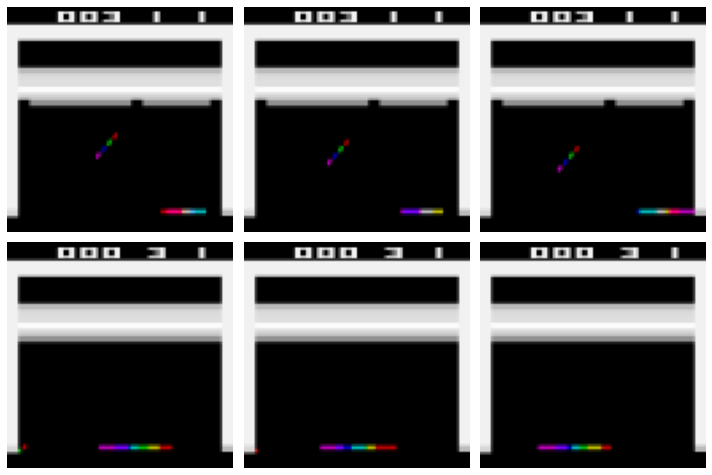

In [121]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

Se crea el dataset:

In [122]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64, #lotes de 64 trayectorias
    num_steps=2, #dos pasos por iteración de entrenamiento
    num_parallel_calls=3).prefetch(3) #se aprovecha la API dataset de TF

Se convierten las funciones a TF Functions para un mejor desempeño:

In [123]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

## Loop principal de entrenamiento

In [124]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size) # estado inicial collect policy
    iterator = iter(dataset) #iterador sobre el dataset
    for iteration in range(n_iterations): #loop entrenamiento
        time_step, policy_state = collect_driver.run(time_step, policy_state) #se ejecuta el driver para coleccionar experencias de 4 pasos y envia trayectorias al replay buffer
        trajectories, buffer_info = next(iterator) #se muestrea lote de experiencias para entrenar el agente
        train_loss = agent.train(trajectories) #se calcula la perdida
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

-- **Las siguientes celdas se pueden ejecutar tantas veces como se quiera, para que el agente siga mejorando!**.

-- **El agente requiere al menos 200.000 iteraciones para que el agente se desempeñe de forma aceptable**.

In [ ]:
train_agent(n_iterations=37500) # 50000 original

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss:0.00217

INFO:absl: 
		 NumberOfEpisodes = 26
		 EnvironmentSteps = 4004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 161.5


1997 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 49
		 EnvironmentSteps = 8004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 167.6999969482422


2997 loss:0.00053

INFO:absl: 
		 NumberOfEpisodes = 75
		 EnvironmentSteps = 12004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 144.60000610351562


3994 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 100
		 EnvironmentSteps = 16004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 160.6999969482422


4998 loss:0.00231

INFO:absl: 
		 NumberOfEpisodes = 125
		 EnvironmentSteps = 20004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 173.0


5996 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 149
		 EnvironmentSteps = 24004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 157.3000030517578


6998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 177
		 EnvironmentSteps = 28004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 151.0


7998 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 202
		 EnvironmentSteps = 32004
		 AverageReturn = 0.5
		 AverageEpisodeLength = 135.3000030517578


8998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 229
		 EnvironmentSteps = 36004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 161.0


9996 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 252
		 EnvironmentSteps = 40004
		 AverageReturn = 2.0999999046325684
		 AverageEpisodeLength = 202.8000030517578


10997 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 275
		 EnvironmentSteps = 44004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 167.6999969482422


11995 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 303
		 EnvironmentSteps = 48004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 152.5


12994 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 326
		 EnvironmentSteps = 52004
		 AverageReturn = 2.4000000953674316
		 AverageEpisodeLength = 195.0


13998 loss:0.00015

INFO:absl: 
		 NumberOfEpisodes = 349
		 EnvironmentSteps = 56004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 141.8000030517578


14996 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 376
		 EnvironmentSteps = 60004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 151.8000030517578


15998 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 402
		 EnvironmentSteps = 64004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 140.3000030517578


16994 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 428
		 EnvironmentSteps = 68004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 140.6999969482422


17994 loss:0.00026

INFO:absl: 
		 NumberOfEpisodes = 451
		 EnvironmentSteps = 72004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 147.8000030517578


18997 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 475
		 EnvironmentSteps = 76004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 187.5


19996 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 499
		 EnvironmentSteps = 80004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 171.1999969482422


20996 loss:0.00024

INFO:absl: 
		 NumberOfEpisodes = 523
		 EnvironmentSteps = 84004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 174.39999389648438


21996 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 547
		 EnvironmentSteps = 88004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 164.5


22998 loss:0.00052

INFO:absl: 
		 NumberOfEpisodes = 567
		 EnvironmentSteps = 92004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 191.0


23998 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 590
		 EnvironmentSteps = 96004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 158.8000030517578


24997 loss:0.00422

INFO:absl: 
		 NumberOfEpisodes = 613
		 EnvironmentSteps = 100004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 158.6999969482422


25997 loss:0.00017

INFO:absl: 
		 NumberOfEpisodes = 636
		 EnvironmentSteps = 104004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 170.89999389648438


26999 loss:0.00045

INFO:absl: 
		 NumberOfEpisodes = 661
		 EnvironmentSteps = 108004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 178.60000610351562


27995 loss:0.00037

INFO:absl: 
		 NumberOfEpisodes = 684
		 EnvironmentSteps = 112004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 164.5


28996 loss:0.00038

INFO:absl: 
		 NumberOfEpisodes = 709
		 EnvironmentSteps = 116004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 155.3000030517578


29998 loss:0.00018

INFO:absl: 
		 NumberOfEpisodes = 734
		 EnvironmentSteps = 120004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 155.3000030517578


30997 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 758
		 EnvironmentSteps = 124004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 151.39999389648438


31995 loss:0.00086

INFO:absl: 
		 NumberOfEpisodes = 783
		 EnvironmentSteps = 128004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 177.60000610351562


32998 loss:0.00247

INFO:absl: 
		 NumberOfEpisodes = 802
		 EnvironmentSteps = 132004
		 AverageReturn = 2.5999999046325684
		 AverageEpisodeLength = 202.39999389648438


33295 loss:0.00179

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

-- **También se puede crear un GIF**:

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
from ipywidgets import Image
from IPython import display
animatedGif = "images/rl/breakout.gif" #path relative to your notebook
file = open(animatedGif , "rb")
image = file.read()
progress= Image(
    value=image,
    format='gif',
    width=100,
    height=100)
display.display(progress)

## Algunos tutoriales útiles: [Checkpointer y Policy Saver](https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial)

# Tarea

-- Estudiar el paper [homl.info/dqn2](homl.info/dqn2]); discuta y compare los conceptos vistos en el curso con los presentados en el paper.

-- Complete el entrenamiento de Breakout con más intereciones y presente un agente competitivo XD

-- Con base a los resultados reportados en el paper anterior, escoja un juego diferente a Breakout y realice el mismo proceso de entrenamiento. Presente y discuta los resultados.

-- Consulte como configurar un Custom TF-Agents Environment y presente un ejemplo de código ilustrativo. ([Ayuda útil](https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb#scrollTo=pYEz-S9gEv2-))